## Grid Search Hyperparameter optimization

This case study is all about using grid searches to identify the optimal parameters for a machine learning algorithm. To complere this case study, you'll use the Pima Indian diabetes dataset from Kaggle and KNN. Follow along with the preprocessing steps of this case study.

Load the necessary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
# set random seed to try make this exercise and solutions reproducible (NB: this is just for teaching purpose and not something you would do in real life)
''' ^ Setting a random seed is not a task restricted to "teaching purpose".
Many "real life" tasks involve generating reproducible results. 
'''
random_seed_number = 42
np.random.seed(random_seed_number)

In [2]:
def hist_subplots(
        data: pd.DataFrame, nrows: int=0, ncols: int=3) -> None:
    '''Create a subplot grid and populate it with histograms of a given
    DataFrame's columns.
    '''
    if not nrows:
        nrows = len(data.columns)//ncols + bool(len(data.columns)%ncols)
    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 8))
    for col, ax in zip(data.columns, axs.flat):
        col_data = data[col].dropna()
        if len(col_data.unique()) < 25:
            bins = len(col_data.unique())
        else:
            bins = np.histogram_bin_edges(col_data, bins='doane')
        ax.hist(col_data, bins=bins, color='#625486')
        ax.set_title(col)
    if len(data.columns)%ncols:
        for _ in range(1, ncols - data.columns%ncols + 1):
            axs[_ * -1].set_axes_off()
    fig.tight_layout()
    plt.show();

#### Load the diabetes data

In [3]:
diabetes_data = pd.read_csv('data/diabetes.csv')
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


**<font color='teal'> Start by reviewing the data info.</font>**

In [4]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


**<font color='teal'> Apply the describe function to the data.</font>**

In [5]:
diabetes_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [6]:
print(f'null count by column\n{"":-<32}')
print(diabetes_data.isnull().sum().to_string())

null count by column
--------------------------------
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0


**<font color='teal'> Currently, the missing values in the dataset are represented as zeros. Replace the zero values in the following columns ['Glucose','BloodPressure','SkinThickness','Insulin','BMI'] with nan .</font>**

In [7]:
diabetes_data.replace(
    {
        column: {0: np.nan} for column in  
        ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    }, inplace=True
)
print(f'null count by column\n{"":-<32}')
print(diabetes_data.isnull().sum().to_string())

null count by column
--------------------------------
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0


**<font color='teal'> Plot histograms of each column. </font>**

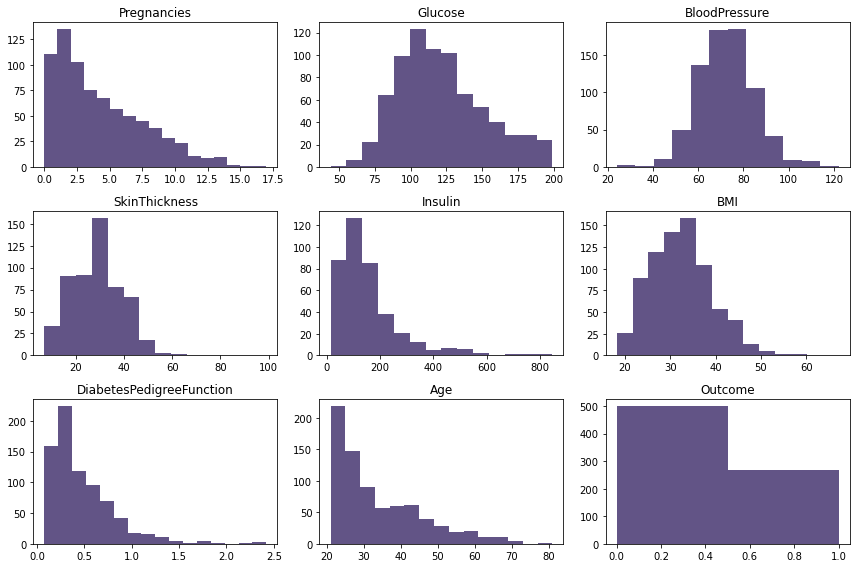

In [8]:
hist_subplots(diabetes_data)

#### Replace the zeros with mean and median values.

In [9]:
diabetes_data['Glucose'].fillna(diabetes_data['Glucose'].mean(), inplace = True)
diabetes_data['BloodPressure'].fillna(diabetes_data['BloodPressure'].mean(), inplace = True)
diabetes_data['SkinThickness'].fillna(diabetes_data['SkinThickness'].median(), inplace = True)
diabetes_data['Insulin'].fillna(diabetes_data['Insulin'].median(), inplace = True)
diabetes_data['BMI'].fillna(diabetes_data['BMI'].median(), inplace = True)

**<font color='teal'> Plot histograms of each column after replacing nan. </font>**

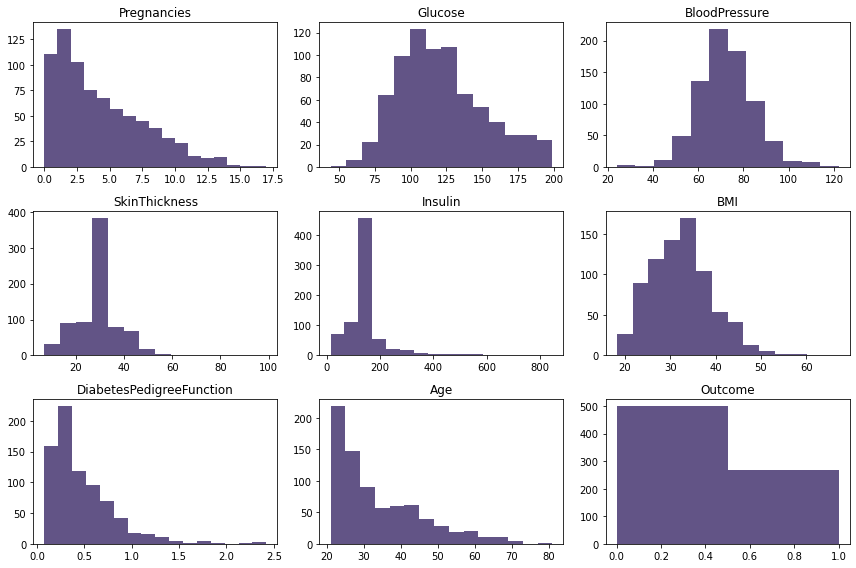

In [10]:
hist_subplots(diabetes_data)

#### Plot the correlation matrix heatmap

Correlation between various features


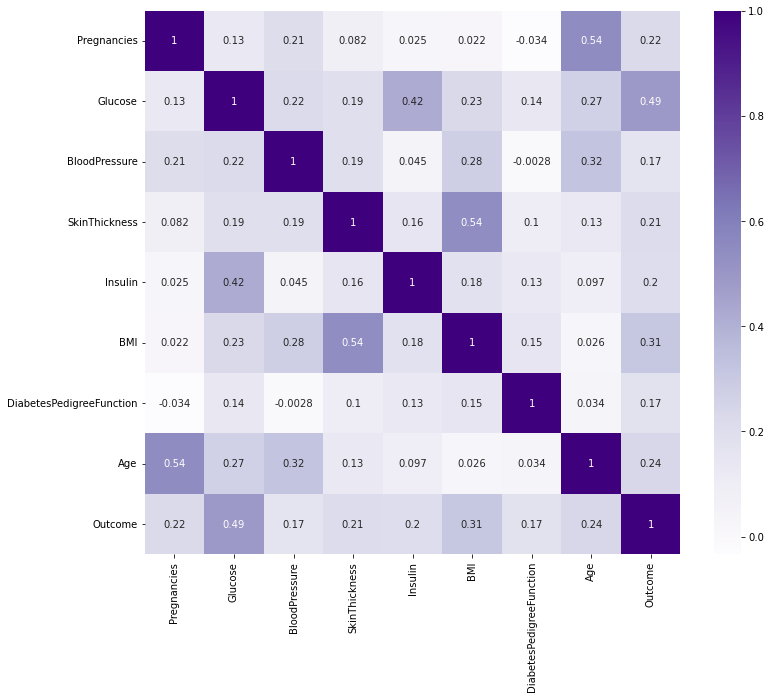

In [11]:
plt.figure(figsize=(12,10))
print('Correlation between various features')
p=sns.heatmap(diabetes_data.corr(), annot=True, cmap='Purples')

**<font color='teal'> Define the `y` variable as the `Outcome` column.</font>**

In [12]:
X = diabetes_data.copy()
y = X.pop('Outcome')
print(f'array shapes\nX: {X.shape}\ny: {y.shape}')

array shapes
X: (768, 8)
y: (768,)


**<font color='teal'> Create a 70/30 train and test split. </font>**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

**<font color='teal'> Using Sklearn, standarize the magnitude of the features by scaling the values. </font>**

Note: Don't forget to fit() your scaler on X_train and then use that fitted scaler to transform() X_test. This is to avoid data leakage while you standardize your data.

In [14]:
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)

#### Using a range of neighbor values of 1-10, apply the KNearestNeighbor classifier to classify the the data.

In [15]:
test_scores = []
train_scores = []

for i in range(1, 11): # modified to include 10

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

**<font color='teal'> Print the train and test scores for each iteration.</font>**

In [16]:
print(f'{f"k":<5}\n{f"scores":>25}\n{f"train":>15}{f"test":>10}\n{"":-<25}')
for k in range(1, 11):
    print(f'{k:<5}{train_scores[k-1]:>10.3f}{test_scores[k-1]:>10.3f}')

k    
                   scores
          train      test
-------------------------
1         1.000     0.667
2         0.851     0.671
3         0.855     0.671
4         0.842     0.693
5         0.840     0.701
6         0.823     0.684
7         0.834     0.732
8         0.821     0.736
9         0.827     0.732
10        0.818     0.719


**<font color='teal'> Identify the number of neighbors that resulted in the max score in the training dataset. </font>**

In [17]:
k = max(
    dict(enumerate(train_scores, 1)), 
    key=dict(enumerate(train_scores, 1)).get
)
print(f'k with max train score: {k}')

k with max train score: 1


**<font color='teal'> Identify the number of neighbors that resulted in the max score in the testing dataset. </font>**

In [18]:
k = max(
    dict(enumerate(test_scores, 1)), 
    key=dict(enumerate(test_scores, 1)).get
)
print(f'k with max test score: {k}')

k with max test score: 8


Plot the train and test model performance by number of neighbors.

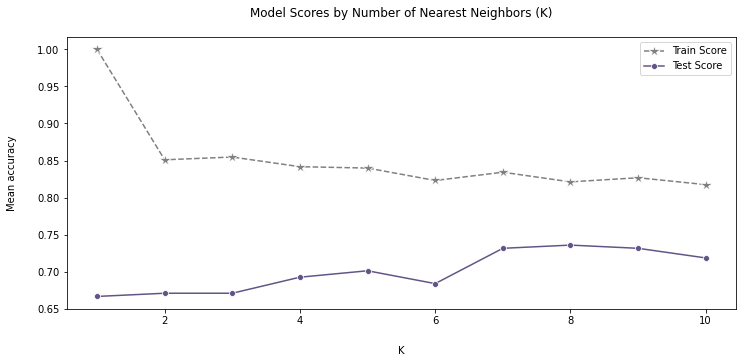

In [19]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(
    x=range(1,11), y=train_scores,marker='*', markersize=12, 
    label='Train Score', color='gray', linestyle='--', ax=ax
)
sns.lineplot(
    x=range(1,11), y=test_scores,marker='o', label='Test Score', 
    color='#625486', ax=ax
);
ax.set_xlabel('K', labelpad=20); ax.set_ylabel('Mean accuracy', labelpad=20)
ax.set_title('Model Scores by Number of Nearest Neighbors (K)', pad=20);


**<font color='teal'> Fit and score the best number of neighbors based on the plot. </font>**

In [20]:
knn = KNeighborsClassifier(k)
knn.fit(X_train, y_train)
print(f'score at k = {k}: ~ {knn.score(X_test, y_test):.3f}')

score at k = 8: ~ 0.736


In [21]:
y_pred = knn.predict(X_test)
pl = confusion_matrix(y_test,y_pred)

**<font color='teal'> Plot the confusion matrix for the model fit above. </font>**

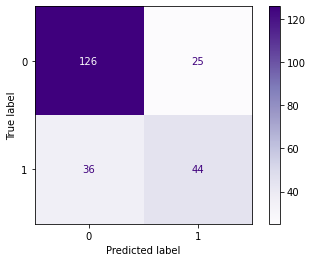

In [22]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Purples');

**<font color='teal'> Print the classification report </font>**

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.83      0.81       151
           1       0.64      0.55      0.59        80

    accuracy                           0.74       231
   macro avg       0.71      0.69      0.70       231
weighted avg       0.73      0.74      0.73       231



#### In the case of the K nearest neighbors algorithm, the K parameter is one of the most important parameters affecting the model performance.  The model performance isn't horrible, but what if we didn't consider a wide enough range of values in our neighbors for the KNN? An alternative to fitting a loop of models is to use a grid search to identify the proper number. It is common practice to use a grid search method for all adjustable parameters in any type of machine learning algorithm. First, you define the grid — aka the range of values — to test in the parameter being optimized, and then compare the model outcome performance based on the different values in the grid.

#### Run the code in the next cell to see how to implement the grid search method for identifying the best parameter value for the n_neighbors parameter. Notice the param_grid is the range value to test and we apply cross validation with five folds to score each possible value of n_neighbors.

In [24]:
param_grid = {'n_neighbors':np.arange(1,50)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X,y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

#### Print the best score and best parameter for n_neighbors.

In [25]:
print(f'Best Score: {knn_cv.best_score_:.2f}')
print(f'Best Parameters: {knn_cv.best_params_}')

Best Score: 0.75
Best Parameters: {'n_neighbors': 31}


Here you can see that the ideal number of n_neighbors for this model is 14 based on the grid search performed. 

<span style='color:rgb(49, 44, 64);'> &emsp; <i>Running all cells with a fresh kernel, the `best_params_` attribute of the `knn_cv` model reliably returns a value of 31. </i></span>

**<font color='teal'> Now, following the KNN example, apply this grid search method to find the optimal number of estimators in a Randon Forest model.
</font>**

In [26]:
r_forest_model = RandomForestClassifier()
param_grid = {
    'n_estimators': np.hstack((
        np.arange(10, 100, 10), np.arange(100, 500, 50), 
        np.arange(500, 1001, 100)
    ))
}
r_forest_cv = GridSearchCV(r_forest_model, param_grid)
r_forest_cv.fit(X, y)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'n_estimators': array([  10,   20,   30,   40,   50,   60,   70,   80,   90,  100,  150,
        200,  250,  300,  350,  400,  450,  500,  600,  700,  800,  900,
       1000])})

In [27]:
print(f'Best Score: {r_forest_cv.best_score_:.2f}')
print(f'Best Parameters: {r_forest_cv.best_params_}')

Best Score: 0.77
Best Parameters: {'n_estimators': 90}
